# CNN + MaxPool
Restructure code.
Alter model design.
CNN,CNN,MaxPool, CNN,CNN,GlobalMaxPool.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-16 18:04:45.702982


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=128 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_LINES = 15   # 15 to analyze all of them
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN \
                    and gene_id in self.gene2rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    cnn3_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn4_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    dens_layer = Dense(DCELLS,activation='relu')
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    cnn.add(cnn3_layer)
    cnn.add(cnn4_layer)
    cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-16 18:05:20.067056
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 128)         4224      
                                                                 
 conv1d_1 (Conv1D)           (None, 4983, 128)         131200    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1244, 128)        0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 1237, 128)         131200    
                                                                 
 conv1d_3 (Conv1D)           (None, 1230, 128)         131200    
                             

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.2f%%' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-16 18:05:20.541650
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4236 sequences.
2023-03-16 18:05:28.745130

Training # 1 1
2023-03-16 18:05:28.745312
2023-03-16 18:05:28.745365
Discriminator ZERO -1
FIT
2023-03-16 18:05:29.970584


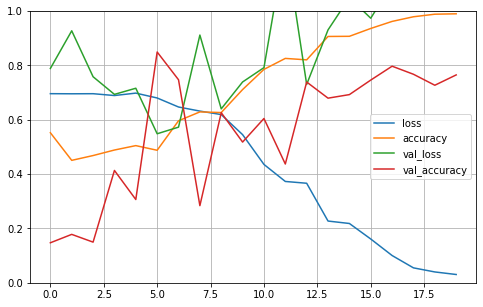


2023-03-16 18:08:53.770684

Testing # 1 1
2023-03-16 18:08:53.770796
2023-03-16 18:08:53.770836
PREDICT
2023-03-16 18:08:53.994366
Test 1:0 718:124 85.27%
Predict 1:0 742:100 88.12%
Test sizes (842, 4997) (842,)
Range of scores: 1.0927926e-05 to 1.0
Score threshold 0.5


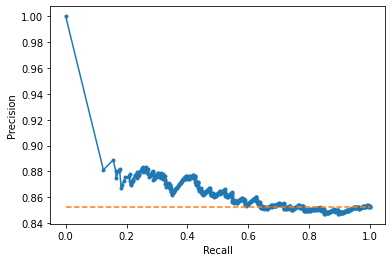

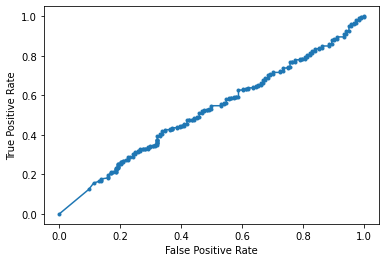

Accuracy: 76.48% Precision: 85.04% Recall: 87.88%
F1: 86.44% MCC: -0.02%
AUPRC: 87.19% AUROC: 51.97%
 accuracy [76.48456057007125]
 precision [85.04043126684635]
 recall [87.88300835654597]
 F1 [86.43835616438355]
 MCC [-0.01788913696518695]
 AUPRC [87.1945196199309]
 AUROC [51.96895498247821]
2023-03-16 18:08:55.638828

Training # 1 2
2023-03-16 18:08:55.641389
2023-03-16 18:08:55.641469
Discriminator ZERO -1
FIT
2023-03-16 18:08:56.878592


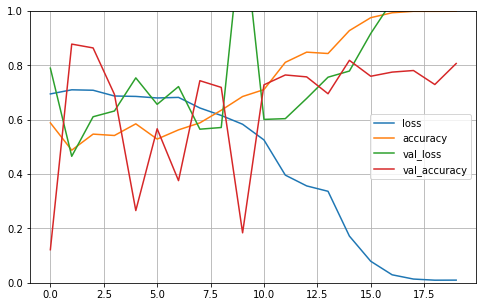


2023-03-16 18:11:23.249626

Testing # 1 2
2023-03-16 18:11:23.249716
2023-03-16 18:11:23.249758
PREDICT
2023-03-16 18:11:23.470267
Test 1:0 750:104 87.82%
Predict 1:0 783:71 91.69%
Test sizes (854, 4997) (854,)
Range of scores: 0.000350531 to 1.0
Score threshold 0.5


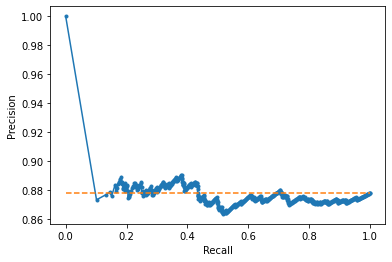

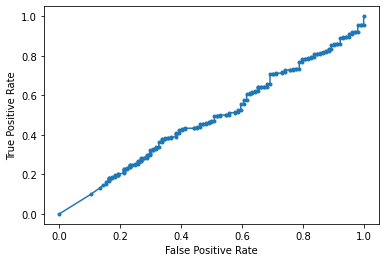

Accuracy: 80.68% Precision: 87.36% Recall: 91.20%
F1: 89.24% MCC: -0.05%
AUPRC: 88.24% AUROC: 48.46%
 accuracy [80.6791569086651]
 precision [87.35632183908046]
 recall [91.2]
 F1 [89.23679060665361]
 MCC [-0.04728912208671943]
 AUPRC [88.24405322935891]
 AUROC [48.46153846153846]
2023-03-16 18:11:25.343346

Training # 1 3
2023-03-16 18:11:25.343534
2023-03-16 18:11:25.343587
Discriminator ZERO -1
FIT
2023-03-16 18:11:26.546712


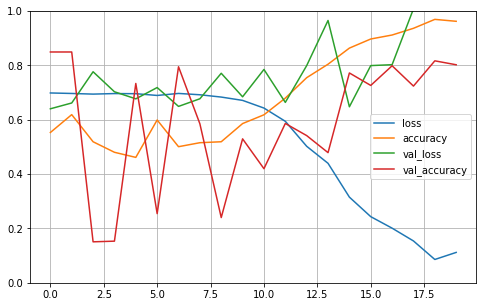


2023-03-16 18:13:53.274817

Testing # 1 3
2023-03-16 18:13:53.274935
2023-03-16 18:13:53.274971
PREDICT
2023-03-16 18:13:53.496009
Test 1:0 704:125 84.92%
Predict 1:0 758:71 91.44%
Test sizes (829, 4997) (829,)
Range of scores: 8.053791e-07 to 1.0
Score threshold 0.5


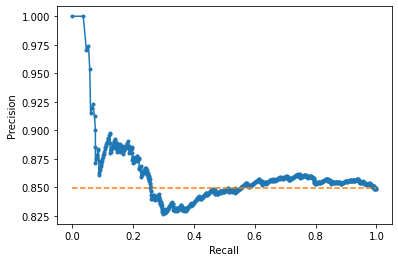

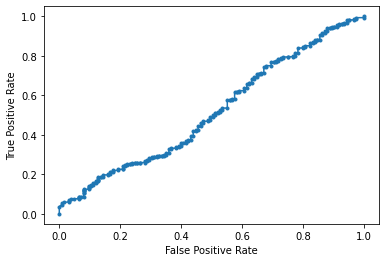

Accuracy: 80.22% Precision: 85.62% Recall: 92.19%
F1: 88.78% MCC: 0.06%
AUPRC: 86.41% AUROC: 51.75%
 accuracy [80.21712907117008]
 precision [85.62005277044855]
 recall [92.1875]
 F1 [88.78248974008207]
 MCC [0.06377646853644002]
 AUPRC [86.40898718905288]
 AUROC [51.745454545454535]
2023-03-16 18:13:55.054644

Training # 1 4
2023-03-16 18:13:55.054861
2023-03-16 18:13:55.054909
Discriminator ZERO -1
FIT
2023-03-16 18:13:56.823998


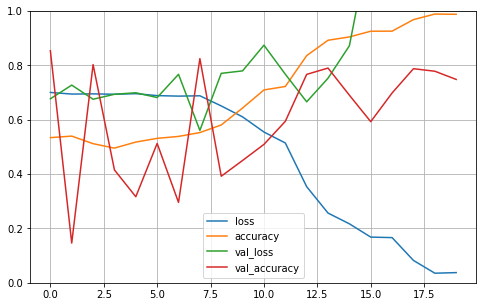


2023-03-16 18:17:20.785622

Testing # 1 4
2023-03-16 18:17:20.786070
2023-03-16 18:17:20.786106
PREDICT
2023-03-16 18:17:21.025911
Test 1:0 736:126 85.38%
Predict 1:0 733:129 85.03%
Test sizes (862, 4997) (862,)
Range of scores: 9.0329175e-09 to 1.0
Score threshold 0.5


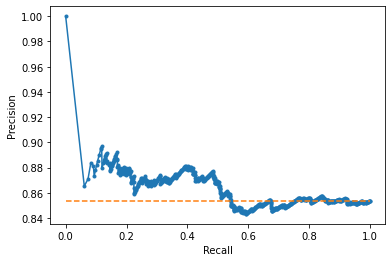

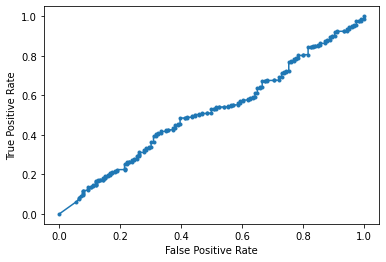

Accuracy: 74.83% Precision: 85.40% Recall: 85.05%
F1: 85.23% MCC: 0.00%
AUPRC: 86.71% AUROC: 51.50%
 accuracy [74.8259860788863]
 precision [85.40245566166439]
 recall [85.05434782608695]
 F1 [85.22804628999319]
 MCC [0.0013241910949362012]
 AUPRC [86.7130149904459]
 AUROC [51.49887853692201]
2023-03-16 18:17:22.606932

Training # 1 5
2023-03-16 18:17:22.607853
2023-03-16 18:17:22.607912
Discriminator ZERO -1
FIT
2023-03-16 18:17:23.977570


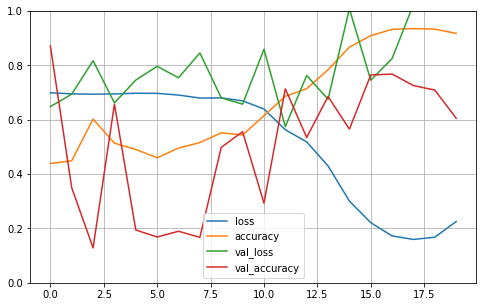


2023-03-16 18:20:47.903352

Testing # 1 5
2023-03-16 18:20:47.903468
2023-03-16 18:20:47.903507
PREDICT
2023-03-16 18:20:48.122358
Test 1:0 740:109 87.16%
Predict 1:0 559:290 65.84%
Test sizes (849, 4997) (849,)
Range of scores: 8.323756e-08 to 1.0
Score threshold 0.5


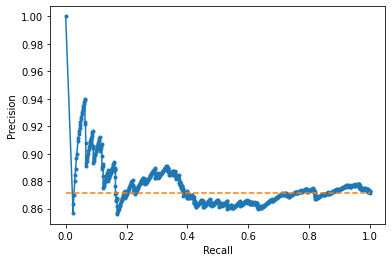

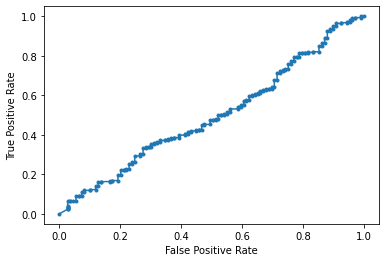

Accuracy: 60.54% Precision: 86.23% Recall: 65.14%
F1: 74.21% MCC: -0.04%
AUPRC: 87.68% AUROC: 49.95%
 accuracy [60.541813898704355]
 precision [86.22540250447227]
 recall [65.13513513513513]
 F1 [74.21093148575828]
 MCC [-0.038845842275657565]
 AUPRC [87.67626962810921]
 AUROC [49.947309695016116]
2023-03-16 18:20:49.661848

Training # 2 1
2023-03-16 18:20:49.662021
2023-03-16 18:20:49.662070
Discriminator ZERO -1
FIT
2023-03-16 18:20:50.877681


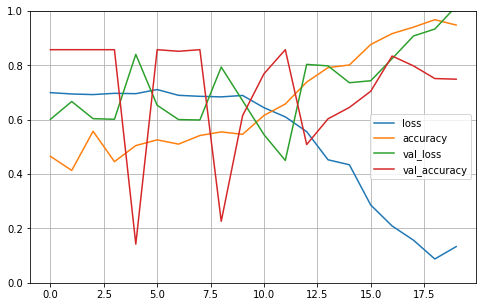


2023-03-16 18:23:17.944833

Testing # 2 1
2023-03-16 18:23:17.944936
2023-03-16 18:23:17.944977
PREDICT
2023-03-16 18:23:18.166717
Test 1:0 735:122 85.76%
Predict 1:0 708:149 82.61%
Test sizes (857, 4997) (857,)
Range of scores: 3.071098e-05 to 1.0
Score threshold 0.5


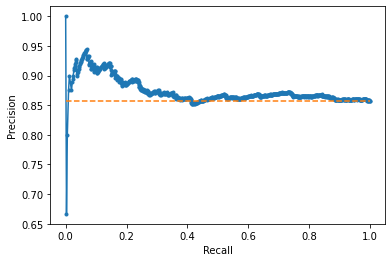

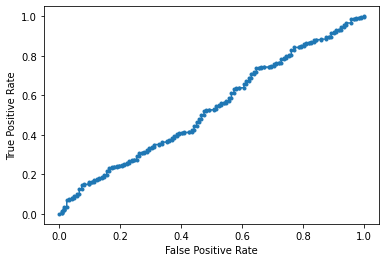

Accuracy: 74.91% Precision: 86.72% Recall: 83.54%
F1: 85.10% MCC: 0.06%
AUPRC: 87.37% AUROC: 53.42%
 accuracy [74.9124854142357]
 precision [86.7231638418079]
 recall [83.53741496598639]
 F1 [85.10048510048509]
 MCC [0.05981916809160771]
 AUPRC [87.37393668441467]
 AUROC [53.41920374707261]
2023-03-16 18:23:20.500151

Training # 2 2
2023-03-16 18:23:20.502691
2023-03-16 18:23:20.503090
Discriminator ZERO -1
FIT
2023-03-16 18:23:22.710546


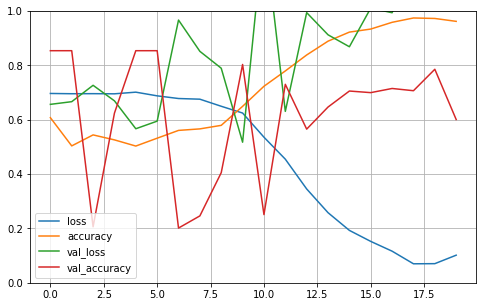


2023-03-16 18:26:46.225312

Testing # 2 2
2023-03-16 18:26:46.225413
2023-03-16 18:26:46.225457
PREDICT
2023-03-16 18:26:46.452363
Test 1:0 725:124 85.39%
Predict 1:0 554:295 65.25%
Test sizes (849, 4997) (849,)
Range of scores: 2.9186602e-08 to 1.0
Score threshold 0.5


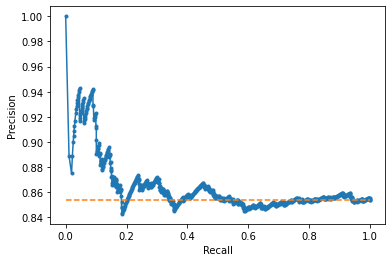

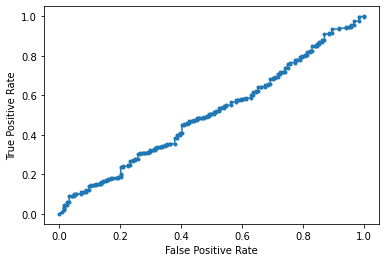

Accuracy: 60.07% Precision: 84.84% Recall: 64.83%
F1: 73.49% MCC: -0.02%
AUPRC: 86.45% AUROC: 50.81%
 accuracy [60.07067137809188]
 precision [84.83754512635379]
 recall [64.82758620689654]
 F1 [73.49491790461298]
 MCC [-0.021615015689129737]
 AUPRC [86.44748745690225]
 AUROC [50.80533926585095]
2023-03-16 18:26:48.116859

Training # 2 3
2023-03-16 18:26:48.117029
2023-03-16 18:26:48.117077
Discriminator ZERO -1
FIT
2023-03-16 18:26:50.275157


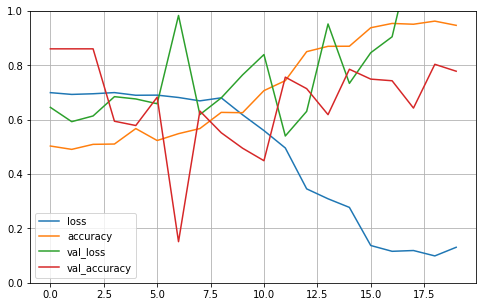


2023-03-16 18:30:14.153913

Testing # 2 3
2023-03-16 18:30:14.153982
2023-03-16 18:30:14.154012
PREDICT
2023-03-16 18:30:14.378682
Test 1:0 711:115 86.08%
Predict 1:0 734:92 88.86%
Test sizes (826, 4997) (826,)
Range of scores: 3.0279332e-06 to 1.0
Score threshold 0.5


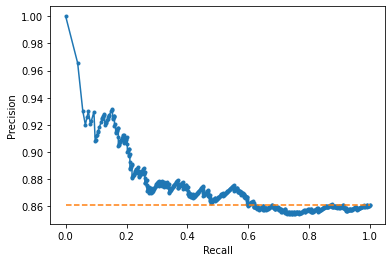

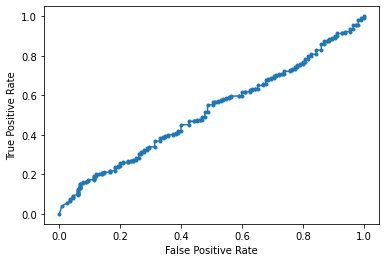

Accuracy: 77.85% Precision: 85.97% Recall: 88.75%
F1: 87.34% MCC: -0.01%
AUPRC: 87.99% AUROC: 51.80%
 accuracy [77.84503631961259]
 precision [85.96730245231608]
 recall [88.74824191279887]
 F1 [87.3356401384083]
 MCC [-0.008989815905745808]
 AUPRC [87.98549807322865]
 AUROC [51.80333883691066]
2023-03-16 18:30:16.123441

Training # 2 4
2023-03-16 18:30:16.123636
2023-03-16 18:30:16.123695
Discriminator ZERO -1
FIT
2023-03-16 18:30:17.697235


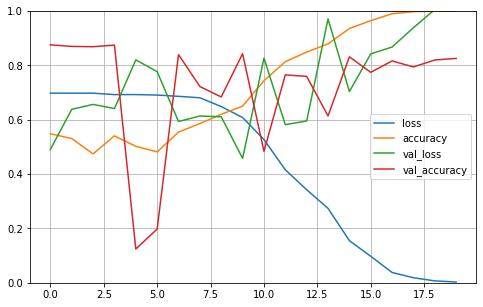


2023-03-16 18:33:41.640707

Testing # 2 4
2023-03-16 18:33:41.641163
2023-03-16 18:33:41.641203
PREDICT
2023-03-16 18:33:41.895202
Test 1:0 753:107 87.56%
Predict 1:0 791:69 91.98%
Test sizes (860, 4997) (860,)
Range of scores: 4.5922385e-05 to 1.0
Score threshold 0.5


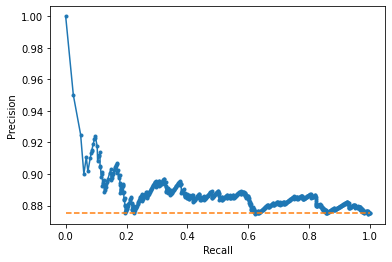

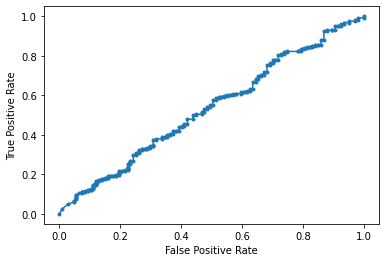

Accuracy: 82.56% Precision: 88.12% Recall: 92.56%
F1: 90.28% MCC: 0.06%
AUPRC: 89.02% AUROC: 53.51%
 accuracy [82.55813953488372]
 precision [88.11630847029078]
 recall [92.56308100929614]
 F1 [90.28497409326424]
 MCC [0.05725829781322618]
 AUPRC [89.01867498992549]
 AUROC [53.509327177272226]
2023-03-16 18:33:43.514322

Training # 2 5
2023-03-16 18:33:43.514525
2023-03-16 18:33:43.514573
Discriminator ZERO -1
FIT
2023-03-16 18:33:44.757273


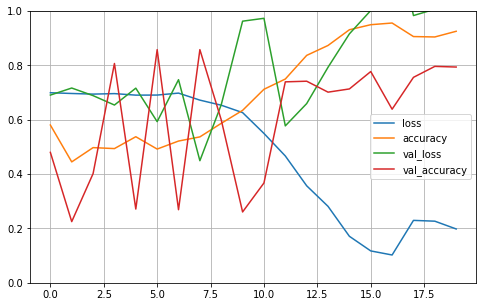


2023-03-16 18:37:08.372423

Testing # 2 5
2023-03-16 18:37:08.372532
2023-03-16 18:37:08.372569
PREDICT
2023-03-16 18:37:08.593328
Test 1:0 724:120 85.78%
Predict 1:0 760:84 90.05%
Test sizes (844, 4997) (844,)
Range of scores: 3.127964e-06 to 1.0
Score threshold 0.5


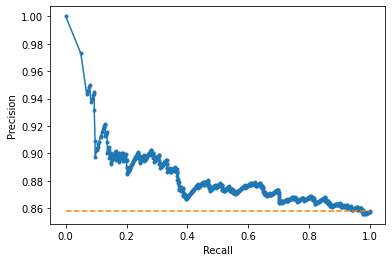

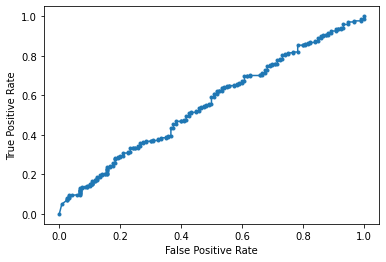

Accuracy: 79.38% Precision: 86.18% Recall: 90.47%
F1: 88.27% MCC: 0.03%
AUPRC: 88.64% AUROC: 55.68%
 accuracy [79.38388625592417]
 precision [86.18421052631578]
 recall [90.4696132596685]
 F1 [88.27493261455525]
 MCC [0.03464282984186625]
 AUPRC [88.63941135413724]
 AUROC [55.67852209944751]
2023-03-16 18:37:09.665522


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 74.75% std 8.01
 precision mean 86.15% std 1.03
 recall mean 84.16% std 10.52
 F1 mean 84.84% std 6.03
 MCC mean 0.01% std 0.04
 AUPRC mean 87.57% std 0.91
 AUROC mean 51.88% std 2.01
 accuracy [[76.48456057007125], [80.6791569086651], [80.21712907117008], [74.8259860788863], [60.541813898704355], [74.9124854142357], [60.07067137809188], [77.84503631961259], [82.55813953488372], [79.38388625592417]]
 precision [[85.04043126684635], [87.35632183908046], [85.62005277044855], [85.40245566166439], [86.22540250447227], [86.7231638418079], [84.83754512635379], [85.96730245231608], [88.11630847029078], [86.18421052631578]]
 recall [[87.88300835654597], [91.2], [92.1875], [85.05434782608695], [65.13513513513513], [83.53741496598639], [64.82758620689654], [88.74824191279887], [92.56308100929614], [90.4696132596685]]
 F1 [[86.43835616438355], [89.23679060665361], [88.78248974008207], [85.22804628999319], [74.21093148575828], [85.10048510048509], [73.49491790461298], [87.3356401384